In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing the necessary modules 
import os
import pandas as pd
from textblob import TextBlob
import pyspark.pandas as ps
from pyspark.sql.functions import (
    pandas_udf, col, udf,expr, from_json, window
)
from pyspark.sql.types import (
    FloatType, StringType, StructType,
    BooleanType, IntegerType
)
from pyspark.sql import SparkSession
from kafka import KafkaConsumer, KafkaProducer
import findspark
import json
import configparser

In [5]:
# Declaring the spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Twitter Sentiment") \
    .getOrCreate()

22/10/19 21:35:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
# config = configparser.ConfigParser()
# config.read('secrets.ini')
# confluent_host = config['confluent_default']['bootstrap.servers']
# confluent_username = config['confluent_default']['sasl.username']
# confluent_password = config['confluent_default']['sasl.password']

# kafka_jaas = """kafkashaded.org.apache.kafka.common.security.plain.PlainLoginModule required username='{}' password='{}';""".format(confluent_username, confluent_password)
# # confluent_consumer.update(config['confluent_consumer'])
# print(kafka_jaas)

In [6]:
# Subscribing to the kafka topic that receives the data and read from it
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "kafka_tweets_stream") \
    .option("startingOffsets", "earliest") \
    .load()

In [7]:
# UDF that classifies the tweets as a positive/negative/neutral sentiment
# Binary classification 
@udf(returnType=StringType())
def sentiment_fxn(text: str):
    try:
        sent_cal = round(float(TextBlob(text).sentiment.polarity), 2)
        if sent_cal > 0:
            return "Postive"
        elif sent_cal < 0:
            return "Negative"
        return "Neutral"
    except:
        return None

In [8]:
# The schema of the streamed data has the expected data represented by the 'value' key
# Using the SQL select statement to cast the binary data as string
my_df = df.selectExpr("CAST(value as STRING)", "timestamp")

In [9]:
# Expected schema of the expected data
sample_schema = (
    StructType()
    .add("created_at", StringType())
    .add("id", IntegerType())
    .add("id_str" , StringType())
    .add("text", StringType())
    .add("source", StringType())
    .add("truncated", BooleanType())
    .add("in_reply_to_status_id", IntegerType())
    .add("in_reply_to_status_id_str", IntegerType())
    .add("in_reply_to_user_id", IntegerType())
    .add("in_reply_to_user_id_str", StringType())
    .add("in_reply_to_screen_name", StringType())
    .add("user", StructType())
    .add("geo", StringType())
    .add("coordinates", StringType())
    .add("place", StringType())
    .add("contributors", StringType())
    .add("retweeted_status", StructType())
    .add("is_quote_status", StringType())
    .add("quote_count", IntegerType())
    .add("reply_count", IntegerType())
    .add("retweet_count", IntegerType())
    .add("favorite_count", IntegerType())
    .add("entities", StructType())
    .add("favorited", BooleanType())
    .add("retweeted", BooleanType())
    .add("possibly_sensitive", StringType())
    .add("filter_level", StringType())
    .add("lang", StringType())
    .add("timestamp_ms", StringType())
)

In [10]:
# Use the schema above to apply on the data
into_dataframe = my_df.select(
        from_json(col("value"), sample_schema).alias("sample"),
    "timestamp"
    )

22/10/19 21:39:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
# Get the data into a dataframe
into_df = into_dataframe.select("sample.*", "timestamp")

In [12]:
# Run the classification function on the text column of the dataframe
sent_df = into_df.withColumn("sentiment", sentiment_fxn(col('text')))

In [ ]:
# Run an aggregate query on the df to enable wrtieStream
# aggDF = sent_df.groupBy('sentiment').count()

In [13]:
# Aggregation with watermark and window
aggDF1 = windowedCounts = sent_df \
    .withWatermark("timestamp", "10 minutes") \
    .groupBy(
        window(sent_df.timestamp, "10 minutes", "5 minutes"),
        'sentiment'
    ).count().orderBy('window')

In [14]:
# Writing the aggregated data to memory as a table so we can perform SQL operations on it
aggDF1.writeStream \
    .queryName("aggregates") \
    .outputMode("complete") \
    .format("memory") \
    .start()

22/10/19 21:39:51 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/ch/1fv_8ny54373dh31wc23mbj00000gn/T/temporary-fb1590e3-c5bc-4884-94ab-7738cf7559d4. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
22/10/19 21:39:51 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [15]:
# Selecting all and converting to pandas df to enable plotting
final_result = spark.sql("select * from aggregates").toPandas()

22/10/19 21:40:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894


In [21]:
# Display the aggregated table
final_result.sort_values('window', ascending=False)

,window,sentiment,count


<AxesSubplot: >

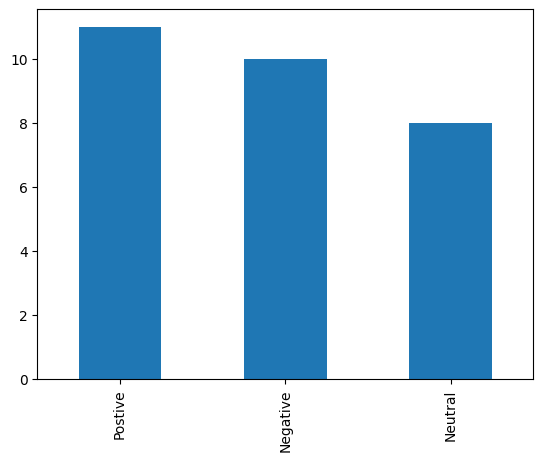

In [22]:
# Plot as a bar graph the various sentiment values
spark.sql("select sentiment, count from aggregates").toPandas()['sentiment'].value_counts().plot.bar('sentiment', 'count')

In [ ]:
# End of File